In [1]:
!nvidia-smi

Sun Feb  5 04:21:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 # Opencv Module

In [5]:
os.chdir('gdrive/My Drive/Classroom/SAE Workshop/test_repo')

In [6]:
pwd

'/content/gdrive/My Drive/Classroom/SAE Workshop/test_repo'

In [10]:
imgbgr = cv2.imread('lane_det.png')
imgrgb = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(imgrgb, cv2.COLOR_RGB2GRAY)

In [12]:
imgrgb.shape

(281, 640, 3)

In [13]:
imgrgb.dtype

dtype('uint8')

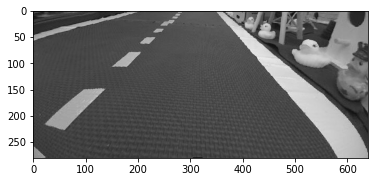

In [14]:
plt.imshow(img,cmap='gray')

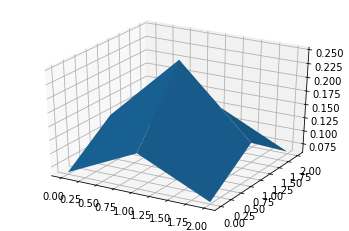

In [16]:
sample = np.array([[1,2,1],[2,4,2],[1,2,1]])/16
x = np.linspace(0,2,3)
y = x.copy()
X, Y = np.meshgrid(x, y)
ax = plt.axes(projection = '3d')
ax.plot_surface(X,Y,sample)

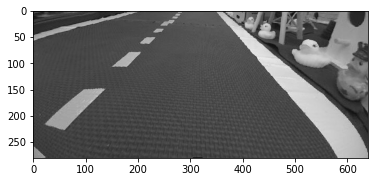

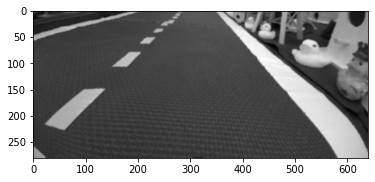

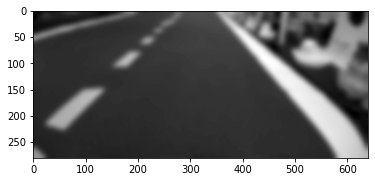

In [18]:
sigma = 1
img_gaussian_filter = cv2.GaussianBlur(img,(0,0),sigma)
plt.imshow(img,cmap='gray')
plt.show()
plt.imshow(img_gaussian_filter,cmap='gray')
sigma = 5
img_gaussian_filter = cv2.GaussianBlur(img,(0,0),sigma)
plt.show()
plt.imshow(img_gaussian_filter,cmap='gray')

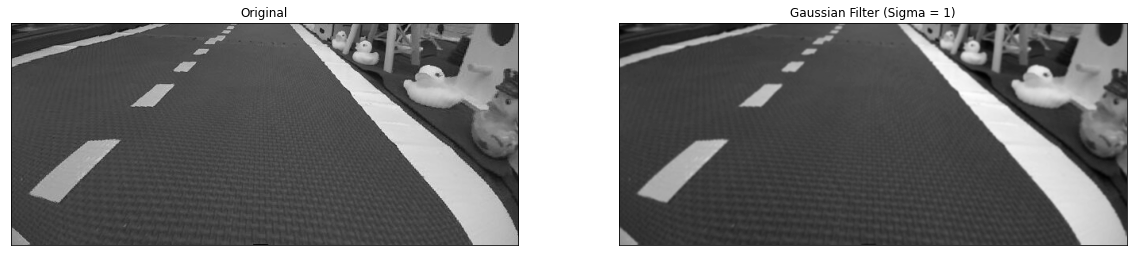

In [19]:
sigma = 1 # heuristic
img_gaussian_filter = cv2.GaussianBlur(img,(0,0),sigma)
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img,cmap = 'gray')
ax1.set_title('Original'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img_gaussian_filter,cmap = 'gray')
ax2.set_title('Gaussian Filter (Sigma = ' + str(sigma) +')'), ax2.set_xticks([]), ax2.set_yticks([]);

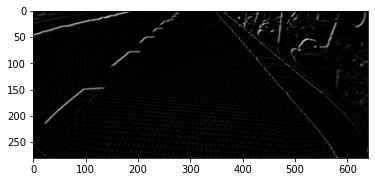

In [22]:
first_order = np.array([[0,0,0],[0,-2,1],[0,1,0]])
filterd_img = cv2.filter2D(img_gaussian_filter,-1,first_order)
plt.imshow(filterd_img,cmap='gray')

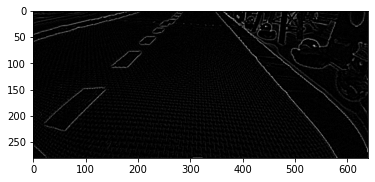

In [23]:
second_order = np.array([[0,1,0],[1,-4,1],[0,1,0]])
filterd_img = cv2.filter2D(img_gaussian_filter,-1,second_order)
plt.imshow(filterd_img,cmap='gray')

In [25]:
first_order

array([[ 0,  0,  0],
       [ 0, -2,  1],
       [ 0,  1,  0]])

In [24]:
second_order

array([[ 0,  1,  0],
       [ 1, -4,  1],
       [ 0,  1,  0]])

(Text(0.5, 1.0, 'Y_Gradients'), [], [])

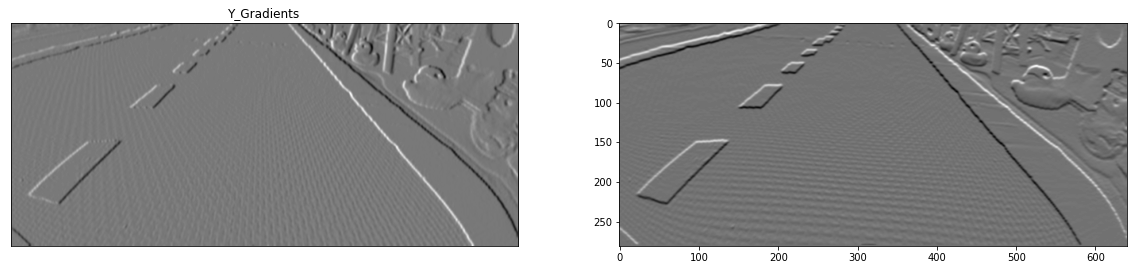

In [26]:
# Sobel Gradients
sobelx = cv2.Sobel(img_gaussian_filter,cv2.CV_64F,1,0)
sobely = cv2.Sobel(img_gaussian_filter,cv2.CV_64F,0,1)
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(sobelx,cmap = 'gray')
ax1.set_title('X_Gradients'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(sobely,cmap = 'gray')
ax1.set_title('Y_Gradients'), ax1.set_xticks([]), ax1.set_yticks([])


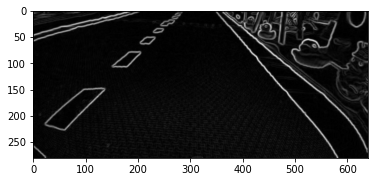

In [27]:
Gmag = np.sqrt(sobelx*sobelx + sobely*sobely)
plt.imshow(Gmag,cmap='gray')

In [29]:
Gmag.dtype

dtype('float64')

Text(0.5, 1.0, 'Histogram of Gradient Magnitude')

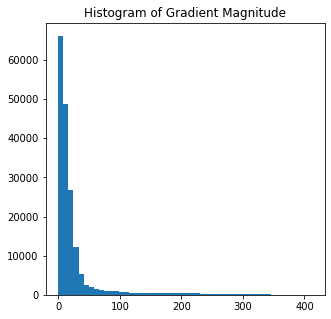

In [33]:
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(1,1,1)
ax1.hist(Gmag.flatten(),bins=50)
ax1.set_title('Histogram of Gradient Magnitude')


bool


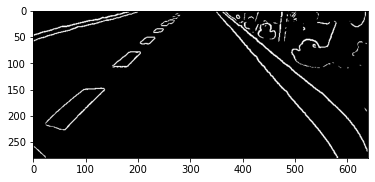

In [37]:
threshold = 170 # heuristic
good_grads = Gmag>threshold
print(good_grads.dtype)
plt.imshow(good_grads,cmap='gray')

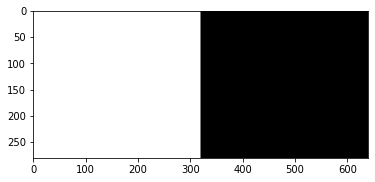

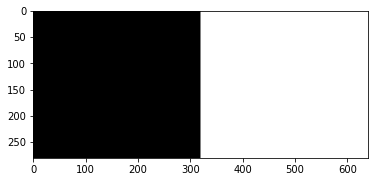

In [38]:
# Let's create masks for the left- and right-halves of the image
width = img.shape[1]
mask_left = np.ones(sobelx.shape)
mask_left[:,int(np.floor(width/2)):width + 1] = 0
mask_right = np.ones(sobelx.shape)
mask_right[:,0:int(np.floor(width/2))] = 0
plt.imshow(mask_left,cmap='gray')
plt.show()
plt.imshow(mask_right,cmap='gray')

In [39]:
mask_sobelx_pos = (sobelx > 0)
mask_sobelx_neg = (sobelx < 0)
mask_sobely_pos = (sobely > 0)
mask_sobely_neg = (sobely < 0)

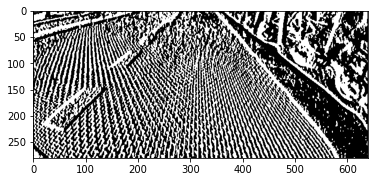

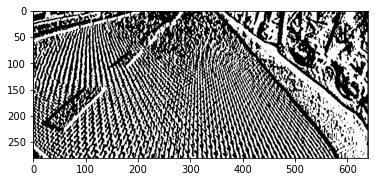

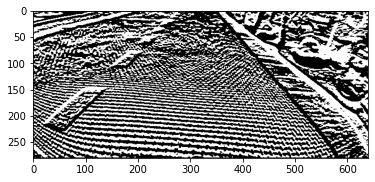

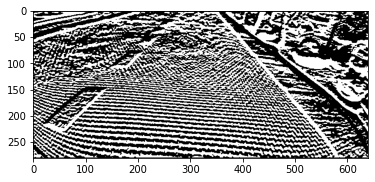

In [40]:
plt.imshow(mask_sobelx_pos,cmap='gray')
plt.show()
plt.imshow(mask_sobelx_neg,cmap='gray')
plt.show()
plt.imshow(mask_sobely_pos,cmap='gray')
plt.show()
plt.imshow(mask_sobely_neg,cmap='gray')


(Text(0.5, 1.0, 'Right_lane'), [], [])

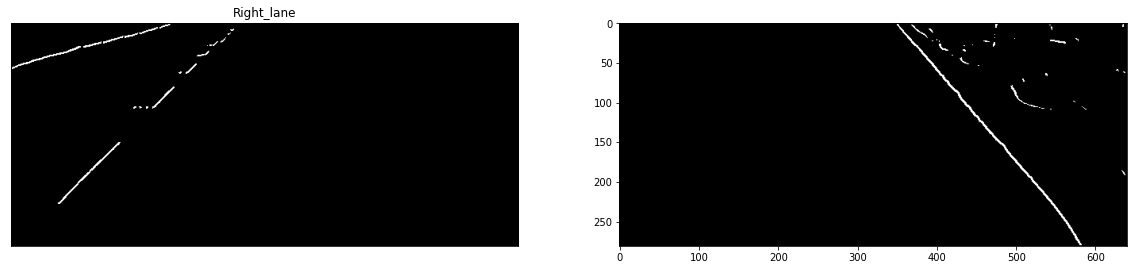

In [41]:
mask_ground = np.ones(img.shape, dtype=np.uint8) # TODO: CHANGE ME
mask_left_edge = mask_ground * mask_left * good_grads * mask_sobelx_neg * mask_sobely_neg
mask_right_edge = mask_ground * mask_right * good_grads * mask_sobelx_pos * mask_sobely_neg
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(mask_left_edge,cmap = 'gray')
ax1.set_title('Left_Lane'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(mask_right_edge,cmap = 'gray')
ax1.set_title('Right_lane'), ax1.set_xticks([]), ax1.set_yticks([])

In [47]:
left_grad_mask = Gmag * mask_left_edge
left_grad_mask=left_grad_mask.astype(np.uint8)
num_labels, labels, stats, centers = cv2.connectedComponentsWithStats(left_grad_mask, connectivity=8, ltype=cv2.CV_32S)
selected_label = []
  
for t in range(1, num_labels, 1):

    _, _, _, _, area = stats[t]
    if area > 40: #Heuristic
        selected_label.append(t)

In [44]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20], dtype=int32)

In [43]:
num_labels

21

In [45]:
selected_label

[6, 8, 11, 16, 20]

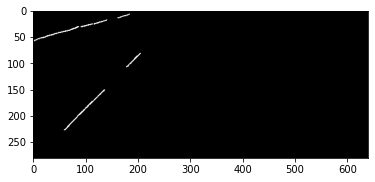

In [48]:
masked_left = mask_ground = np.zeros(img.shape, dtype=np.uint8)

for i in selected_label:
  masked_left[labels==i]=1
plt.imshow(masked_left,cmap='gray')

In [57]:
right_grad_mask = Gmag * mask_right_edge
right_grad_mask=right_grad_mask.astype(np.uint8)
num_labels, labels, stats, centers = cv2.connectedComponentsWithStats(right_grad_mask, connectivity=8, ltype=cv2.CV_32S)
selected_label = []
  
for t in range(1, num_labels, 1):

    _, _, _, _, area = stats[t]
    if area > 100: #Heuristic
        selected_label.append(t)

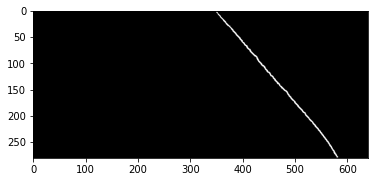

In [58]:
masked_right = mask_ground = np.zeros(img.shape, dtype=np.uint8)

for i in selected_label:
  masked_right[labels==i]=1
plt.imshow(masked_right,cmap='gray')

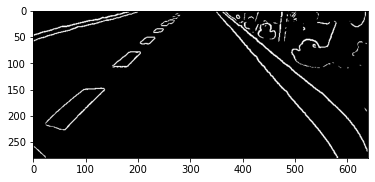

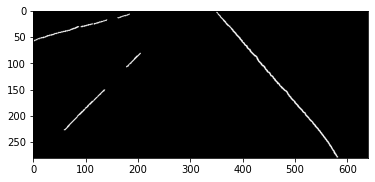

In [59]:
total_masked = masked_left+masked_right
plt.imshow(good_grads,cmap='gray')
plt.show()
plt.imshow(total_masked,cmap='gray')